## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 172kB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.13MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [10]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 10]           2,570
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.07
----------------------------------------------------------------


Your experiments come here:

In [12]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
def train(model, loader, loss_func, optimizer):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, loss_func):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

num_epochs = 15
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, loss_func, opt)
    test_loss, test_acc = evaluate(model, test_loader, loss_func)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Epoch 01: Train Loss: 0.5536 | Train Acc: 0.8015 | Test Loss: 0.4240 | Test Acc: 0.8482
Epoch 02: Train Loss: 0.3885 | Train Acc: 0.8583 | Test Loss: 0.3801 | Test Acc: 0.8621
Epoch 03: Train Loss: 0.3547 | Train Acc: 0.8690 | Test Loss: 0.3642 | Test Acc: 0.8683
Epoch 04: Train Loss: 0.3300 | Train Acc: 0.8783 | Test Loss: 0.3568 | Test Acc: 0.8721
Epoch 05: Train Loss: 0.3132 | Train Acc: 0.8850 | Test Loss: 0.3686 | Test Acc: 0.8637
Epoch 06: Train Loss: 0.2999 | Train Acc: 0.8887 | Test Loss: 0.3439 | Test Acc: 0.8747
Epoch 07: Train Loss: 0.2901 | Train Acc: 0.8914 | Test Loss: 0.3367 | Test Acc: 0.8751
Epoch 08: Train Loss: 0.2784 | Train Acc: 0.8966 | Test Loss: 0.3471 | Test Acc: 0.8741
Epoch 09: Train Loss: 0.2713 | Train Acc: 0.8978 | Test Loss: 0.3201 | Test Acc: 0.8851
Epoch 10: Train Loss: 0.2609 | Train Acc: 0.9012 | Test Loss: 0.3271 | Test Acc: 0.8819
Epoch 11: Train Loss: 0.2538 | Train Acc: 0.9047 | Test Loss: 0.3217 | Test Acc: 0.8836
Epoch 12: Train Loss: 0.2483 | T

In [14]:
_, test_acc = evaluate(model, test_loader, loss_func)
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.8898


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 1,494,154
Trainable params: 1,494,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.70
Estimat

In [21]:
subset_size = 1000
train_indices = torch.arange(subset_size)
reduced_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, train_indices)
train_loader = torch.utils.data.DataLoader(reduced_train_dataset, batch_size=128, shuffle=True)

In [18]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
num_epochs = 50
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, loss_func, opt)
    test_loss, test_acc = evaluate(model, test_loader, loss_func)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")



Epoch 01: Train Loss: 2.0910 | Train Acc: 0.3060 | Test Loss: 1.5207 | Test Acc: 0.5218
Epoch 02: Train Loss: 1.2333 | Train Acc: 0.5580 | Test Loss: 0.9711 | Test Acc: 0.5863
Epoch 03: Train Loss: 0.9772 | Train Acc: 0.6150 | Test Loss: 0.9154 | Test Acc: 0.6067
Epoch 04: Train Loss: 0.8556 | Train Acc: 0.6600 | Test Loss: 0.8470 | Test Acc: 0.6504
Epoch 05: Train Loss: 0.7390 | Train Acc: 0.7010 | Test Loss: 0.7695 | Test Acc: 0.7082
Epoch 06: Train Loss: 0.6622 | Train Acc: 0.7520 | Test Loss: 0.7185 | Test Acc: 0.7418
Epoch 07: Train Loss: 0.5874 | Train Acc: 0.7950 | Test Loss: 0.7557 | Test Acc: 0.7230
Epoch 08: Train Loss: 0.5384 | Train Acc: 0.8050 | Test Loss: 0.7327 | Test Acc: 0.7395
Epoch 09: Train Loss: 0.4923 | Train Acc: 0.8190 | Test Loss: 0.7199 | Test Acc: 0.7384
Epoch 10: Train Loss: 0.4280 | Train Acc: 0.8390 | Test Loss: 0.6532 | Test Acc: 0.7725
Epoch 11: Train Loss: 0.3857 | Train Acc: 0.8630 | Test Loss: 0.6432 | Test Acc: 0.7722
Epoch 12: Train Loss: 0.3418 | T

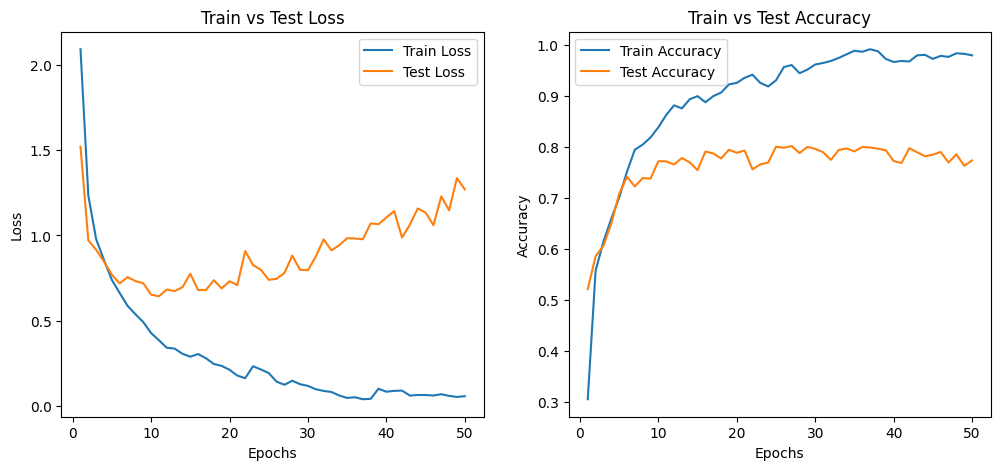

In [19]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

In [23]:
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Final Test Accuracy: 0.7740


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [22]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)

        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [24]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [25]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
num_epochs = 30
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_loader, loss_func, opt)
    test_loss, test_acc = evaluate(model, test_loader, loss_func)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01: Train Loss: 2.1811 | Train Acc: 0.2310 | Test Loss: 2.1676 | Test Acc: 0.4581
Epoch 02: Train Loss: 1.6848 | Train Acc: 0.4780 | Test Loss: 1.6291 | Test Acc: 0.5839
Epoch 03: Train Loss: 1.3546 | Train Acc: 0.5920 | Test Loss: 1.2088 | Test Acc: 0.6569
Epoch 04: Train Loss: 1.1561 | Train Acc: 0.6620 | Test Loss: 1.0077 | Test Acc: 0.7022
Epoch 05: Train Loss: 1.0082 | Train Acc: 0.7060 | Test Loss: 0.9066 | Test Acc: 0.7155
Epoch 06: Train Loss: 0.9123 | Train Acc: 0.7170 | Test Loss: 0.8184 | Test Acc: 0.7333
Epoch 07: Train Loss: 0.8190 | Train Acc: 0.7480 | Test Loss: 0.7588 | Test Acc: 0.7411
Epoch 08: Train Loss: 0.7402 | Train Acc: 0.7700 | Test Loss: 0.7061 | Test Acc: 0.7555
Epoch 09: Train Loss: 0.6575 | Train Acc: 0.8080 | Test Loss: 0.6691 | Test Acc: 0.7659
Epoch 10: Train Loss: 0.6077 | Train Acc: 0.8190 | Test Loss: 0.6541 | Test Acc: 0.7653
Epoch 11: Train Loss: 0.5662 | Train Acc: 0.8260 | Test Loss: 0.6318 | Test Acc: 0.7828
Epoch 12: Train Loss: 0.5340 | T

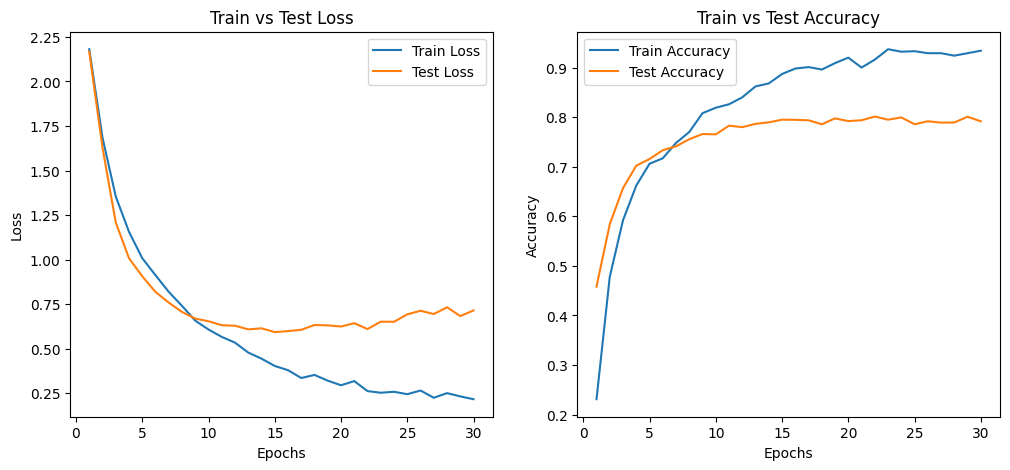

In [26]:
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

In [27]:
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Final Test Accuracy: 0.7916


### Conclusions:
Слишком глубокие нейронные сети склонны к переобучению на небольших датасетах. Применение регуляризационных техник, таких как Dropout, Batch Normalization и раннее завершение обучения (30 эпох вместо 50), позволяет снизить переобучение, что приводит к уменьшению функции потерь и повышению точности на тестовой выборке